1. 프로젝트 : Data Labeling

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [12]:
modify_data = pd.read_csv('/aiffel/data/sub_upbit_eth_min_tick.csv',index_col=0, parse_dates=True )

<AxesSubplot:xlabel='time'>

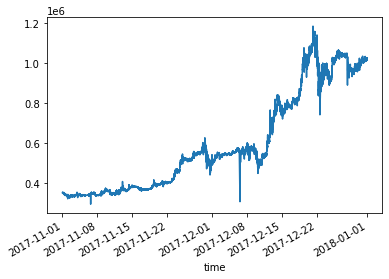

In [13]:
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

① Price Change Direction 적용하기

In [14]:
# Q. 코드를 작성해주세요

# window 지정
window = 10 

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1) # modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal) # 데이터 활용을 위해 pd.Series를 사용합니다.

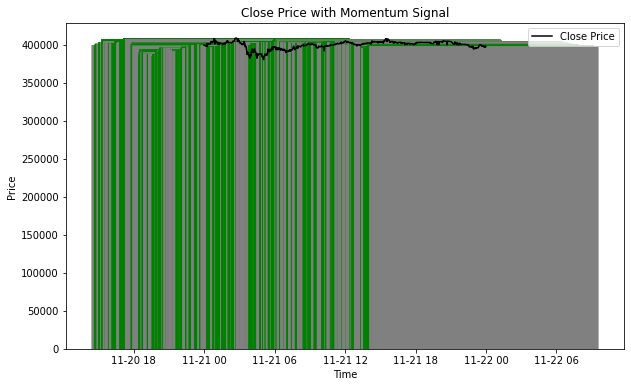

In [15]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21':, 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig =  modify_data.loc['2017-11-21', ['close']] # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(momentum_signal.loc['2017-11-21'] == 1, 'green', 
                          np.where(momentum_signal.loc['2017-11-21'] == -1, 'red','gray'))


# 시각화하기
plt.figure(figsize=(10, 6))
plt.plot(c_sig.index, c_sig['close'], color='black', label='Close Price')
plt.bar(c_sig.index, c_sig['close'], color=c_sig['color'], alpha=0.6)
plt.title('Close Price with Momentum Signal')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

② Using Moving Average 적용하기

In [6]:

# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1) # modify_data['close'].rolling(window).mean() 활용

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal) # pd.Series로 변환

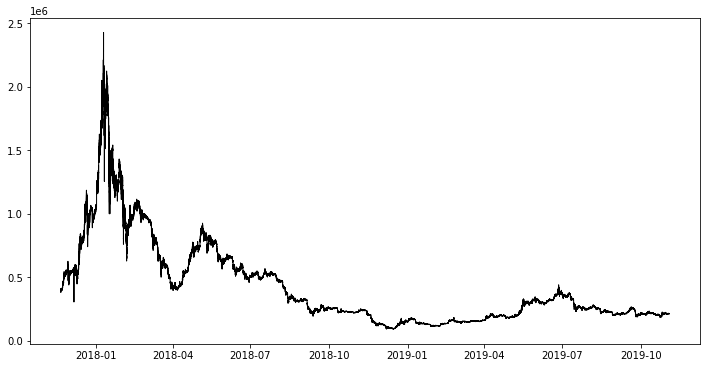

In [46]:

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21':, 'close']

# 수식 적용된 데이터 만들기
moving_average = modify_data['close'].rolling(window).mean()

# 두 데이터의 비교를 위한 색상 바꾸기
color = np.where(modify_data['close'] > moving_average, 'green', 
                 np.where(modify_data['close'] < moving_average, 'red', 'gray'))
# 시각화하기
plt.figure(figsize=(12, 6))
plt.plot(sub_data.index, sub_data, label='Close Price', color='black', linewidth=1)
# plt.plot(moving_average.index, moving_average, label='Moving Average', color='blue', linestyle='--', linewidth=2)
# plt.bar(sub_data.index, sub_data, color=color, alpha=0.6)

plt.show()

③ Local Min-Max 적용하기

In [49]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            max_idxes.append(idx)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return mins, maxes, min_idxes, max_idxes

In [98]:
# Local mins, maxes를 확인
mins, maxes,min_idxes, max_idxes = get_local_min_max(sub_data, wait=3)


# # mins, maxes 확인 
# print(mins)
# print('--'*20)
# print(maxes)

293193 293193
0 473136


ValueError: x and y must be the same size

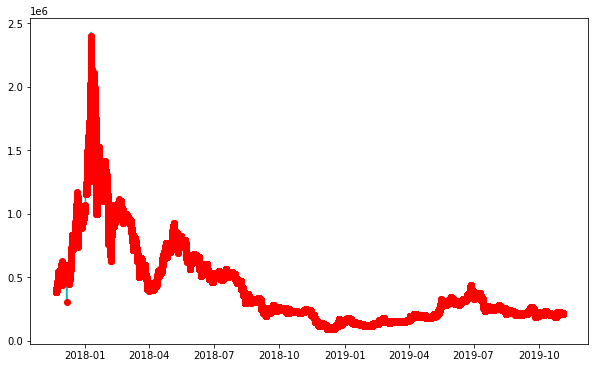

In [59]:
# subplots 및 plot 생성

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(min_idxes, mins, color='red', label='Local Min', zorder=5)

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(max_idxes, maxes, color='blue', label='Local Max', zorder=5) 

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

plt.show()

④ Trend Scanning 적용하기

In [62]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [63]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [66]:
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(tval)  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

  0%|          | 0/33384 [00:32<?, ?it/s]


KeyboardInterrupt: 

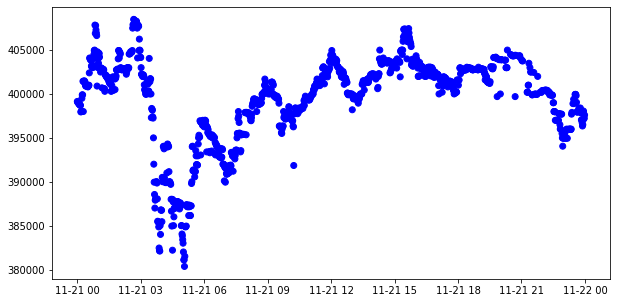

In [65]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

2. 프로젝트 : Feature Engineering

① 환경구성 및 데이터 불러오기

In [16]:
!pip install ta==0.9.0
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28907 sha256=73172dad81bd2e8ae5eed002662c9b87901ab7de189630835d0094b1f4a4a3ee
  Stored in directory: /aiffel/.cache/pip/wheels/d1/3c/c4/176cfd752bd625c697799269715459e85c6dfd9500df26ad93
Successfully built ta
     |████████████████████████████████| 539 kB 4.1 MB/s            


In [17]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [18]:
데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

② Technical Index 적용하기

In [19]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [20]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [21]:
# Q. 코드를 작성해주세요

df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y =  df_tmp_data.iloc[:,-1] 

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [22]:
# Q. 코드를 작성해주세요

# RandomForest 모델 적용
rfc =  RandomForestClassifier(n_estimators=100, random_state=42) 

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(random_state=42)

③ Feature Selection methods 적용하기

MDI, Mean Decrease Impurity

In [23]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.039110,0.001788
volume_fi,0.041509,0.002297
volume_mfi,0.049099,0.002929
volume_sma_em,0.034699,0.001726
volume_vpt,0.024173,0.001320
volatility_atr,0.075890,0.003291
volatility_ui,0.048859,0.002219
trend_macd_diff,0.084576,0.004312
trend_adx,0.052292,0.002201
trend_trix,0.065693,0.002647


MDA, Mean Decrease Accuracy

In [24]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) 
cv = KFold(n_splits=7) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [27]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

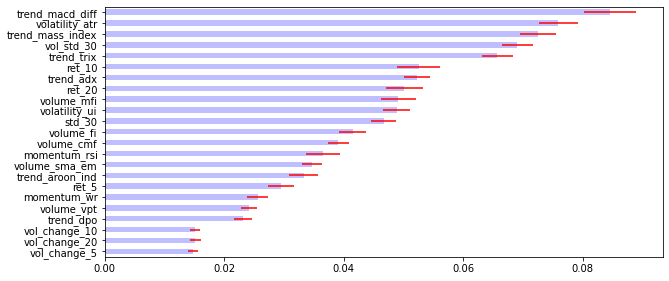

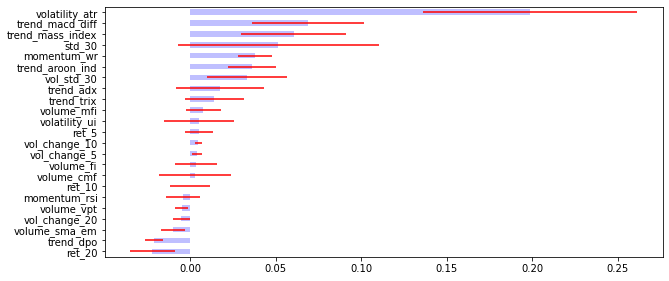

In [33]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)
                        

RFE CV, Recursive Feature Elimination


In [34]:

# RFE CV, Recursive Feature Elimination

svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(estimator=svc_rbf, step=1, cv=5, scoring='accuracy')
rfe_fitted = rfe_cv.fit(X_sc, y)

In [38]:

print("Selected features:", X_sc.columns[rfe_fitted.support_])

Selected features: Index(['volume_fi', 'volatility_atr', 'trend_macd_diff', 'trend_aroon_ind',
       'momentum_rsi', 'momentum_wr', 'ret_20', 'std_30'],
      dtype='object')


SFS, Sequential Feature Selection

In [39]:
# SFS, Sequential Feature Selection

n = 5 
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [40]:
print("Selected features:", X_sc.columns[sfs_fitted.get_support()])

Selected features: Index(['volume_mfi', 'trend_macd_diff', 'trend_adx', 'trend_dpo',
       'vol_change_20'],
      dtype='object')


3. 프로젝트 : Model Traning

① 환경구성 및 데이터 불러오기

In [75]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')

from libs.mlutil.pkfold import PKFold

In [77]:
# # 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_data = pd.read_pickle(data_file_name)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:500] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:500]

② Purged K-fold for Cross-Validation적용하기

In [99]:
# # Q. 코드를 작성해주세요

n_cv = 5  
t1 = pd.Series(train_y.index.values, index=train_y.index)

# # purged K-Fold 
cv = PKFold(t1, n_splits = n_cv)


TypeError: __init__() got multiple values for argument 'n_splits'

③ Model 적용하기

In [100]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

In [101]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [102]:
# Q. 코드를 작성해주세요

# Bagging 적용
bag_rfc =BaggingClassifier(base_estimator=rfc, n_estimators=10, random_state=42)

In [104]:
# Q. 코드를 작성해주세요

# GridSearchCV 적용
gs_rfc = GridSearchCV(estimator=bag_rfc, 
                      param_grid=bc_params, 
                      cv=cv, 
                      scoring='accuracy', 
                      n_jobs=-1, 
                      verbose=1)

In [ ]:
# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator
gs_rfc_best.fit(train_x, train_y)

Fitting 7 folds for each of 288 candidates, totalling 2016 fits


In [ ]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [ ]:
# Q. 코드를 작성해주세요

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision =precision_score(test_y, pred_y) 
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [ ]:
# Q. 코드를 작성해주세요

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])
auc = roc_auc_score(test_y, prob_y[:, 1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show

print(f'auc:{auc}')